Geostrophic and Ageostrophic Wind
=================================

Plot a 1000-hPa map calculating the geostrophic from MetPy and finding the
ageostrophic wind from the total wind and the geostrophic wind.

This uses the geostrophic wind calculation from `metpy.calc` to find
the geostrophic wind, then performs the simple subtraction to find the ageostrophic
wind. Currently, this needs an extra helper function to calculate
the distance between lat/lon grid points.

Additionally, we utilize the `ndimage.zoom` method for smoothing the 1000-hPa
height contours without smoothing the data.

Imports

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import scipy.ndimage as ndimage

from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog

Set up access to the data

In [2]:
dt = datetime(2016, 8, 22, 18)
forecast_hour = 3
h = timedelta(hours=forecast_hour)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-gfs-g4-anl-files-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_00{forecast_hour}.grb2'].subset()

# Create NCSS query for our desired time, region, and data variables
query = ncss.query()
                 
query.lonlat_box(north=50, south=30, east=-80, west=-115)
query.time(dt + h)
query.variables('Geopotential_height_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')
query.vertical_level(100000)
                 
data = ncss.get_data(query)

In [3]:
# Pull out variables you want to use
height_var = data.variables['Geopotential_height_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']

# Find the name of the time coordinate
for name in height_var.coordinates.split():
    if name.startswith('time'):
        time_var_name = name
        break
time_var = data.variables[time_var_name]

lat_var = data.variables['lat']
lon_var = data.variables['lon']

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
height = height_var[0, 0, :, :].squeeze()
u_wind = u_wind_var[0, 0, :, :].squeeze() * units('m/s')
v_wind = v_wind_var[0, 0, :, :].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = num2pydate(time_var[:].squeeze(), time_var.units)

In [4]:
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Smooth height data
height = ndimage.gaussian_filter(height, sigma=1.5, order=0)

# Set up some constants based on our projection, including the Coriolis parameter and
# grid spacing, converting lon/lat spacing to Cartesian
f = mpcalc.coriolis_parameter(np.deg2rad(lat_2d)).to('1/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lon_2d, lat_2d)

# In MetPy 0.5, geostrophic_wind() assumes the order of the dimensions is (X, Y),
# so we need to transpose from the input data, which are ordered lat (y), lon (x).
# Once we get the components,transpose again so they match our original data.
geo_wind_u, geo_wind_v = mpcalc.geostrophic_wind(height * units.m, f, dx, dy)
geo_wind_u = geo_wind_u
geo_wind_v = geo_wind_v

# Calculate ageostrophic wind components
ageo_wind_u = u_wind - geo_wind_u
ageo_wind_v = v_wind - geo_wind_v

Text(0.5, 1.0, '1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \nAgeostrophic Wind(green) for 22 August 2016 21:00Z')

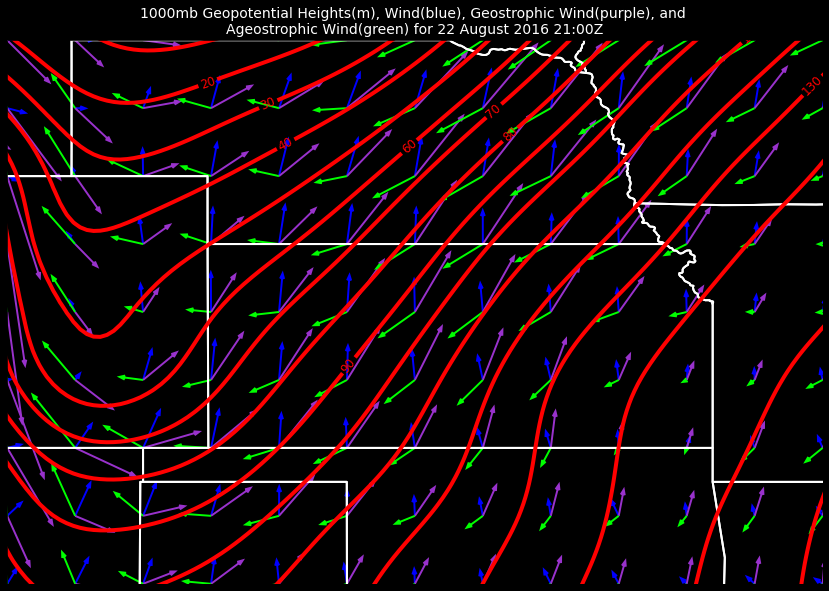

In [5]:
# Create new figure
fig = plt.figure(figsize=(15, 10), facecolor='black')

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105., -93., 35., 43.])
ax.patch.set_fill(False)

# Add state boundaries to plot
ax.add_feature(cfeature.STATES, edgecolor='white', linewidth=2)

# Contour the heights every 10 m
contours = np.arange(10, 200, 10)
# Because we have a very local graphics area, the contours have joints
# to smooth those out we can use `ndimage.zoom`
zoom_500 = ndimage.zoom(height, 5)
zlon = ndimage.zoom(lon_2d, 5)
zlat = ndimage.zoom(lat_2d, 5)
c = ax.contour(zlon, zlat, zoom_500, levels=contours,
               colors='red', linewidths=4)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=3, fmt='%i')

# Set up parameters for quiver plot. The slices below are used to subset the data (here
# taking every 4th point in x and y). The quiver_kwargs are parameters to control the
# appearance of the quiver so that they stay consistent between the calls.
quiver_slices = (slice(None, None, 2), slice(None, None, 2))
quiver_kwargs = {'headlength': 4, 'headwidth': 3, 'angles': 'uv', 'scale_units': 'xy',
                 'scale': 20}

# Plot the wind vectors
wind = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 u_wind[quiver_slices], v_wind[quiver_slices],
                 color='blue', **quiver_kwargs)
geo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                geo_wind_u[quiver_slices], geo_wind_v[quiver_slices],
                color='darkorchid', **quiver_kwargs)
ageo = ax.quiver(lon_2d[quiver_slices], lat_2d[quiver_slices],
                 ageo_wind_u[quiver_slices], ageo_wind_v[quiver_slices],
                 color='lime', **quiver_kwargs)

# Add a title to the plot
plt.title('1000mb Geopotential Heights(m), Wind(blue), Geostrophic Wind(purple), and \n'
          f'Ageostrophic Wind(green) for {time:%d %B %Y %H:%MZ}', color='white', size=14)